In [180]:
#Import packages
import requests
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from io import StringIO

%matplotlib inline
params = {'legend.fontsize': 'x-large',
      'figure.figsize': (12, 6),
      'axes.labelsize': 'x-large',
      'axes.titlesize': 'x-large',
      'xtick.labelsize': 'x-large',
      'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
headers = {'user-agent': '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

In [199]:
#Definition of functions
def market_data(date: str) -> pd.DataFrame:
    """Get the market data from TWSE"""
    data = requests.post('https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + date + '&type=ALL')
    df = pd.read_csv(StringIO(data.text.replace("=", "")), header=["證券代號" in l for l in data.text.split("\n")].index(True)-1)
    return df

def Ins_data(date: str) -> pd.DataFrame:
    """Get the Net Buy/Sell of Three Institutional Investors"""
    res = requests.get('http://www.tse.com.tw/fund/T86?response=csv&date='+date+'&selectType=ALLBUT0999')
    df_Ins = pd.read_csv(StringIO(res.text), header=1).dropna(how='all', axis=1).dropna(how='any')
    return df_Ins

def select_stocks(date: str, trading_volume: int=1000000, PE_ratio: int=30, net_buy_foreign: int=100000, net_buy_investment_trust: int=100000) -> pd.DataFrame:
    """Select stocks based on PE ratio and the Net Buy/Sell of Three Institutional Investors"""
    df = market_data(date).drop(columns = ["證券名稱" , "最後揭示買價" , "最後揭示買量" , "最後揭示賣價" , "最後揭示賣量" , "Unnamed: 16", 
                                           "漲跌(+/-)", "漲跌價差" , "成交筆數" , "開盤價" , "最高價" , "最低價"] )

    df = df[-df["收盤價"].isin(["--"])]
    df['成交股數'] = df['成交股數'].apply(lambda str: float(str.replace(',', '')))
    df['成交金額'] = df['成交金額'].apply(lambda str: float(str.replace(',', '')))
    df['收盤價'] = df['收盤價'].apply(lambda str: float(str.replace(',', '')))
    df['本益比'] = df['本益比'].apply(lambda str: float(str.replace(',', '')))
    df = df.set_index("證券代號") 
    df = df[(df["成交股數"] > trading_volume) & (df["本益比"] != 0) & (df["本益比"] < PE_ratio)]
    
    
    df_Ins = Ins_data(date).drop(columns = ["證券名稱" , "外陸資買進股數(不含外資自營商)" , "外陸資賣出股數(不含外資自營商)" , "外資自營商買進股數" ,
                              "外資自營商賣出股數" , "投信買進股數" , "投信賣出股數" , "自營商買進股數(自行買賣)" , 
                              "自營商賣出股數(自行買賣)" , "自營商買進股數(避險)" , "自營商賣出股數(避險)" , "外資自營商買賣超股數" , 
                              "自營商買賣超股數" , "自營商買賣超股數(自行買賣)" , "自營商買賣超股數(避險)" , "三大法人買賣超股數"] )
    df_Ins["外陸資買賣超股數(不含外資自營商)"] = df_Ins["外陸資買賣超股數(不含外資自營商)"].apply(lambda str: float(str.replace(',', '')))
    df_Ins["投信買賣超股數"] = df_Ins["投信買賣超股數"].apply(lambda str: float(str.replace(',', ''))) 
    df_Ins = df_Ins.set_index("證券代號")
    df_Ins = df_Ins[(df_Ins["外陸資買賣超股數(不含外資自營商)"] > net_buy_foreign) & (df_Ins["投信買賣超股數"] > net_buy_investment_trust)]
    df_final = pd.merge(df , df_Ins , on = ["證券代號"])
    
    return(df_final)

In [201]:
#Portfolio
df = select_stocks('20200930')
df = df.drop('2456')

stocks = ''
for i in range(len(df.index)):
    stocks += f'{df.index[i]}'+'.tw, '
stocks

prices = yf.download(stocks, start='2020-09-30', end='2020-12-30')['Close']
prices['sum'] = prices.sum(axis=1)
prices['cum_return_rate'] = prices['sum'].apply(lambda x: (x/prices['sum'][0])-1)

#Stock market index
market_index = pd.DataFrame(yf.download('^twii', start='2020-09-30', end='2020-12-30')['Close'])
market_index['cum_return_rate'] = market_index['Close'].apply(lambda x: (x/market_index['Close'][0])-1)

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed


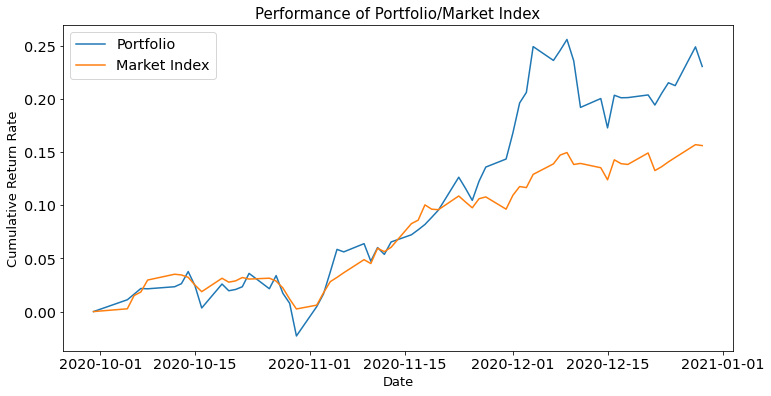

In [202]:
#Plot the performance
x = prices.index
y1 = prices['cum_return_rate']
y2 = market_index['cum_return_rate']
plt.plot(x,y1)
plt.plot(x,y2)
plt.title("Performance of Portfolio/Market Index",fontsize=15)
plt.xlabel("Date",fontsize=13)
plt.ylabel("Cumulative Return Rate",fontsize=13)
plt.legend(['Portfolio', 'Market Index'])
plt.show()